# Project 2 Ames Housing
## Pipeline linear modeling

In this section, we combined the modeling results from the Ordinary Least Squares (OLS) and Pipeline modeling sections to create a combined model.    


## Import libraries

In [163]:
# Imports:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_regression, RFE

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score

from sklearn.model_selection import GridSearchCV

from scipy import stats
import statsmodels.api as sm

from itertools import combinations

%matplotlib inline

# Set the graph style
sns.set_style('whitegrid')

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## Read in Data

In [164]:
# Set relative data path
data_path = "../datasets"
test_dataframe_name = "test_expanded_clean.csv"
train_dataframe_name = "train_expanded_clean.csv"
y_trn_dataframe_name = "y_clean.csv"

X1_trn = pd.read_csv(os.path.join(data_path, train_dataframe_name))
X1_tst = pd.read_csv(os.path.join(data_path, test_dataframe_name))
y_trn = pd.read_csv(os.path.join(data_path, y_trn_dataframe_name))

print(X1_trn.shape, X1_tst.shape, y_trn.shape)

(2051, 802) (879, 802) (2051, 1)


## Split the data in training and test sets

In [165]:
# Split the training data
X1_trn_trn, X1_trn_tst, y_trn_trn, y_trn_tst = train_test_split(X1_trn, y_trn, random_state=223)


## Pull in the variable lists from OLS and Pipeline

In [166]:
lr_coeff = ['over_qual', 'gr_liv_area', 'garg_area', 'garg_cars', '1st_flr_sf', 'age_home_at_sale', 
            'age_remodel_at_sale', 'fireplcs', 'bsmt_fin_sf', 'opn_prch_sf', 'neigh_Blueste', 'neigh_BrDale', 
            'neigh_BrkSide', 'neigh_ClearCr', 'neigh_CollgCr', 'neigh_Crawfor', 'neigh_Edwards', 
            'neigh_Gilbert', 'neigh_Greens', 'neigh_GrnHill', 'neigh_IDOTRR', 'neigh_Landmrk', 
            'neigh_MeadowV', 'neigh_Mitchel', 'neigh_NAmes', 'neigh_NPkVill', 'neigh_NWAmes', 'neigh_NoRidge', 
            'neigh_NridgHt', 'neigh_OldTown', 'neigh_SWISU', 'neigh_Sawyer', 'neigh_SawyerW', 'neigh_Somerst', 
            'neigh_StoneBr', 'neigh_Timber', 'neigh_Veenker', 'bld_type_2fmCon', 'bld_type_Duplex', 
            'bld_type_Twnhs', 'bld_type_TwnhsE', 'kit_qual_Fa', 'kit_qual_Gd', 'kit_qual_Po', 'kit_qual_TA']

pl_coeff = ['over_qual', '1st_flr_sf', 'over_qual tot_bsmt_sf',
           'over_qual gr_liv_area', 'over_qual yr_sold', 'tot_bsmt_sf gr_liv_area',
           'tot_bsmt_sf yr_sold', 'tot_bsmt_sf tot_rms_abv_grd',
           'tot_rms_abv_grd 1st_flr_sf']


coeff = lr_coeff[:] + [x for x in pl_coeff if x not in lr_coeff ]

print(coeff)

           

['over_qual', 'gr_liv_area', 'garg_area', 'garg_cars', '1st_flr_sf', 'age_home_at_sale', 'age_remodel_at_sale', 'fireplcs', 'bsmt_fin_sf', 'opn_prch_sf', 'neigh_Blueste', 'neigh_BrDale', 'neigh_BrkSide', 'neigh_ClearCr', 'neigh_CollgCr', 'neigh_Crawfor', 'neigh_Edwards', 'neigh_Gilbert', 'neigh_Greens', 'neigh_GrnHill', 'neigh_IDOTRR', 'neigh_Landmrk', 'neigh_MeadowV', 'neigh_Mitchel', 'neigh_NAmes', 'neigh_NPkVill', 'neigh_NWAmes', 'neigh_NoRidge', 'neigh_NridgHt', 'neigh_OldTown', 'neigh_SWISU', 'neigh_Sawyer', 'neigh_SawyerW', 'neigh_Somerst', 'neigh_StoneBr', 'neigh_Timber', 'neigh_Veenker', 'bld_type_2fmCon', 'bld_type_Duplex', 'bld_type_Twnhs', 'bld_type_TwnhsE', 'kit_qual_Fa', 'kit_qual_Gd', 'kit_qual_Po', 'kit_qual_TA', 'over_qual tot_bsmt_sf', 'over_qual gr_liv_area', 'over_qual yr_sold', 'tot_bsmt_sf gr_liv_area', 'tot_bsmt_sf yr_sold', 'tot_bsmt_sf tot_rms_abv_grd', 'tot_rms_abv_grd 1st_flr_sf']


## Define functions

In [306]:
def view_lr_summary(X,y):    
    # Use stats models to generate a summary of the regression
    # Copy the X and y and reset index of y to be equal to x
    X1 = X.copy()
    y1 = y.copy()
    y1.index = X1.index
    X1 = sm.add_constant(X1)
    model = sm.OLS(y1, X1)
    results =  model.fit()
    # return the results
    return results.summary()


def eval_model(y_act, y_pred):
    
    # Make a copy of the y_act dataframe
    df = y_act.copy()
    # Copy y_pred into the data frame
    try:
        df['pred'] = [x[0] for x in y_pred]
    except:
        df['pred'] = [x for x in y_pred]
    
    df.columns=['act','pred']
    # create residuals
    df['res'] = df['act'] - df['pred']
    # get the r2 score
    r2 = r2_score(df['act'], df['pred'])
    # do the normality test
    k2, p = stats.normaltest(df['res'])
    
    # specify your figsize and the number of plots on that figure
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (15,12))

    fig.suptitle('Model analysis', fontsize = 16)
    
    # Plot the scatter of the predicted versus actual
    ax[0][0] = sns.scatterplot('act','pred', data=df, ax = ax[0][0])
    ax[0][0] = sns.lineplot('act','act', data=df, ax = ax[0][0], color = 'grey')
    ax[0][0].set_title('Predicted versus actuals', fontsize = 14)
    ax[0][0].set_xlabel('Actuals', fontsize = 12)
    ax[0][0].set_ylabel('Predicted', fontsize = 12)
    ax[0][0].text(.25, .75, f"$R^2$ {r2:.4}", horizontalalignment='left',
                  size='large', color='grey', weight='semibold', transform=ax[0][0].transAxes)
    ax[0][0].grid(False)
    
    # Plot the scatter of the residuals versus actuals
    ax[0][1] = sns.scatterplot(x = 'act',y = 'res', data=df, ax = ax[0][1])
    ax[0][1].set_title('Residuals versus actuals', fontsize = 14)
    ax[0][1].set_xlabel('Actuals', fontsize = 12)
    ax[0][1].set_ylabel('Residuals', fontsize = 12)
    ax[0][1].axhline(y=0, color = 'grey')
    ax[0][1].grid(False)
    
    # Plot the residuals
    ax[1][0] = sns.scatterplot(x = df.index,y = 'res', data=df, ax = ax[1][0])
    ax[1][0].set_title('Residuals versus an index', fontsize = 14)
    ax[1][0].set_xlabel('Index', fontsize = 12)
    ax[1][0].set_ylabel('Residuals', fontsize = 12)
    ax[1][0].axhline(y=0, color = 'grey')
    ax[1][0].grid(False)
    
    # Plot the histogram of residuals
    ax[1][1] = sns.distplot( df['res'], ax = ax[1][1])
    ax[1][1].set_title('Histogram of residuals', fontsize = 14)
    ax[1][1].set_xlabel('Residuals', fontsize = 12)
    ax[1][1].set_ylabel('Distribution', fontsize = 12)
    ax[1][1].text(.05,.95, f"p value for $H_0$: residuals are normal {r2:.4}", 
                  horizontalalignment='left', size='large', color='grey', weight='semibold', 
                  transform=ax[1][1].transAxes)
    ax[1][1].grid(False)
    
    # https://stackoverflow.com/questions/26097916/convert-pandas-series-to-dataframe
    # https://www.blog.pythonlibrary.org/2018/03/13/python-3-an-intro-to-f-strings/
    # https://jakevdp.github.io/PythonDataScienceHandbook/04.09-text-and-annotation.html

    
def write_pred(df, out_file):
    # Open the test file to get the ID
    test_file_name = "test.csv"
    a_tst = pd.read_csv(os.path.join(data_path, test_file_name))
    pred_out = a_tst[['Id']].join(df).sort_values(by='Id')
    # Save the predictions to a csv file
    pred_out.to_csv(os.path.join(data_path, out_file), header = ['Id','SalePrice'], index = False)


def correl_plot(df, c_title, figsize, annot=True):
    # Examine correlations of the participation rates and scores
    fig = plt.figure(figsize=figsize)
    mask = np.triu(np.ones_like(df.corr()))
    ax = sns.heatmap(df.corr(), 
                     annot = annot,
                     annot_kws = {"size" : 12},
                     mask=mask,
                     cmap = "gist_earth")
    ax.set_title(c_title, fontsize = 14)
    ax.tick_params(axis="x", rotation = 90, labelsize = 12)
    ax.tick_params(axis="y", rotation = 0, labelsize = 12)
    y_min, y_max = ax.get_ylim()
    x_min, x_max = ax.get_xlim()
    ax.set_ylim(top=y_max+1)
    ax.set_xlim(right=x_max-1)
    # Credit Douglas Strodtman from the Abalone example

 
# Function to evaluate the introduction of a categorical variable against models
def cat_evaluator(X, y, cat_lists, var_combos, min_cat, max_cat, linear_model = 'line_regr'):

    # Instantiate the linear regression model
    if linear_model == 'line_regr':
        lm = LinearRegression()
    elif linear_model == 'lasso':
        lm = LassoCV(n_alphas = 100, cv = 5)
    elif linear_model == 'ridge':
        lm = RidgeCV(alphas=np.linspace(.1, 10, 100), cv = 5)
    else:
        return
    
    # Set up the model list
    model_library = []

    # for each category list in the cat_lists
    # add the category variables (in a list) to each variable combination in var_combos
    for i in range(min_cat, max_cat + 1):
        # Get the combination of cat_lists
        combos = combinations(cat_lists, i)
        for combo in combos:
            cat_list = []
            for category in combo:
                cat_list += category
            for var_combo in var_combos:              
                feat_sub = var_combo[:]
                feat_sub.extend(cat_list)
                # Create a new X with a subset of features
                X_sub = X[feat_sub]
                # fit the model and generate predictions
                model = lm.fit(X_sub, y)
                pred = model.predict(X_sub)
                # score the model 
                score_cv = cross_val_score(lm, X_sub, y, cv= 5).mean()
                # save this model in a list of dictionaries
                model_library.append({
                    'Model': linear_model,
                    'Combo': feat_sub,
                    'CV R2': score_cv,
                    'Intercept': model.intercept_,
                    'Coeff' : model.coef_,
                    'Pred' : pred,
                })

    return pd.DataFrame(model_library)


def large_scatter(y_act, y_pred):
     # Make a copy of the y_act dataframe
    df = y_act.copy()
    # Copy y_pred into the data frame
    try:
        df['pred'] = [x[0] for x in y_pred]
    except:
        df['pred'] = [x for x in y_pred]
    
    df.columns=['act','pred']
    # create residuals
    df['res'] = df['act'] - df['pred']
    # get the r2 score
    r2 = r2_score(df['act'], df['pred'])
    # do the normality test
    k2, p = stats.normaltest(df['res'])
    
    # specify your figsize and the number of plots on that figure
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (16,14))

    # Plot the scatter of the predicted versus actual
    ax = sns.scatterplot('act','pred', data=df, ax = ax, s=200, legend = False)
    ax = sns.lineplot('act','act', data=df, ax = ax, color = 'grey', size=['act'], sizes = [5], legend = False)
    ax.set_title('Predicted versus actuals', fontsize = 40, color = 'grey', weight = 'semibold')
    ax.set_xlabel('Actuals', fontsize = 30, color = 'grey', weight = 'semibold')
    ax.set_ylabel('Predicted', fontsize = 30, color = 'grey',weight = 'semibold')
    ax.tick_params(axis="x", labelsize=25)
    ax.tick_params(axis='y', labelsize=25)
    ax.text(.25, .75, f"$R^2$ {r2:.4}", horizontalalignment='left', fontsize = 40,
                  color='grey', weight='semibold', transform=ax.transAxes)
    ax.grid(False)
 
    

## Put these variables in an OLS model

In [284]:
# Instantiate the model
lr = LinearRegression()
model_lr = lr.fit(X1_trn_trn[coeff], y_trn_trn)
pred_lr_pl_trn_tst = model_lr.predict(X1_trn_tst[coeff])
print(cross_val_score(lr,X1_trn[coeff],y_trn, cv = 5).mean())


0.8978770431650013


## Evaluate the model


### Use the statsmodels api to see a summary of the regression

In [169]:
#  Use stats models to view a summary of the regression
view_lr_summary(X1_trn_trn[coeff], y_trn_trn)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             sale_price   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     298.6
Date:                Thu, 21 Mar 2019   Prob (F-statistic):               0.00
Time:                        07:21:23   Log-Likelihood:                -17652.
No. Observations:                1538   AIC:                         3.541e+04
Df Residuals:                    1486   BIC:                         3.569e+04
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                        1.532e+05   1.17e+04     13.110      0.000     1.3e+05    1.76e+05
over_qual                   -7.464e+04   1.55e+05     -0.483      0.629   -3.78e+05    2.29e+05
gr_liv_area                     6.6270      6.754      0.981      0.327      -6.622      19.876
garg_area                      14.6956      6.960      2.111      0.035       1.043      28.348
garg_cars                    2762.8647   1995.843      1.384      0.166   -1152.105    6677.835
1st_flr_sf                     44.2379      8.979      4.927      0.000      26.625      61.851
age_home_at_sale             -227.1739     48.007     -4.732      0.000    -321.343    -133.004
age_remodel_at_sale          -301.7256     44.742     -6.744      0.000    -389.490    -213.962
fireplcs                     5603.4546   1230.355      4.554      0.000    3190.037    8016.872
bsmt_fin_sf                    22.0767      1.721     12.831      0.000      18.702      25.452
opn_prch_sf                    -2.8468     10.274     -0.277      0.782     -22.999      17.306
neigh_Blueste                7714.2740   1.35e+04      0.572      0.568   -1.87e+04    3.42e+04
neigh_BrDale                  1.08e+04   9445.717      1.144      0.253   -7724.148    2.93e+04
neigh_BrkSide               -1.179e+04   7657.958     -1.539      0.124   -2.68e+04    3233.883
neigh_ClearCr                8206.6087   8405.883      0.976      0.329   -8282.050    2.47e+04
neigh_CollgCr               -1.491e+04   6601.343     -2.258      0.024   -2.79e+04   -1958.242
neigh_Crawfor                7527.6193   7378.141      1.020      0.308   -6945.059     2.2e+04
neigh_Edwards               -1.611e+04   7044.427     -2.288      0.022   -2.99e+04   -2296.442
neigh_Gilbert               -1.207e+04   6818.332     -1.770      0.077   -2.54e+04    1306.575
neigh_Greens                -7604.6152   1.81e+04     -0.421      0.674   -4.31e+04    2.78e+04
neigh_GrnHill                1.113e+05    1.8e+04      6.191      0.000     7.6e+04    1.47e+05
neigh_IDOTRR                 -2.07e+04   7893.032     -2.623      0.009   -3.62e+04   -5218.034
neigh_Landmrk                1901.7737   2.49e+04      0.076      0.939    -4.7e+04    5.08e+04
neigh_MeadowV               -7116.5403   8595.249     -0.828      0.408    -2.4e+04    9743.570
neigh_Mitchel               -1.307e+04   7106.721     -1.839      0.066    -2.7e+04     873.648
neigh_NAmes                 -1.446e+04   6854.647     -2.110      0.035   -2.79e+04   -1014.424
neigh_NPkVill                  20.5198   9640.763      0.002      0.998   -1.89e+04    1.89e+04
neigh_NWAmes                -1.806e+04   7051.696     -2.561      0.011   -3.19e+04   -4227.557
neigh_NoRidge                8311.3055   7587.356      1.095      0.274   -6571.762    2.32e+04
neigh_Nridg

### Look for multicollinearity

From the above results, it is clear that this model suffers for multicollinearity issues and that the coefficients and predictions may not be valid when applied to new data sets.


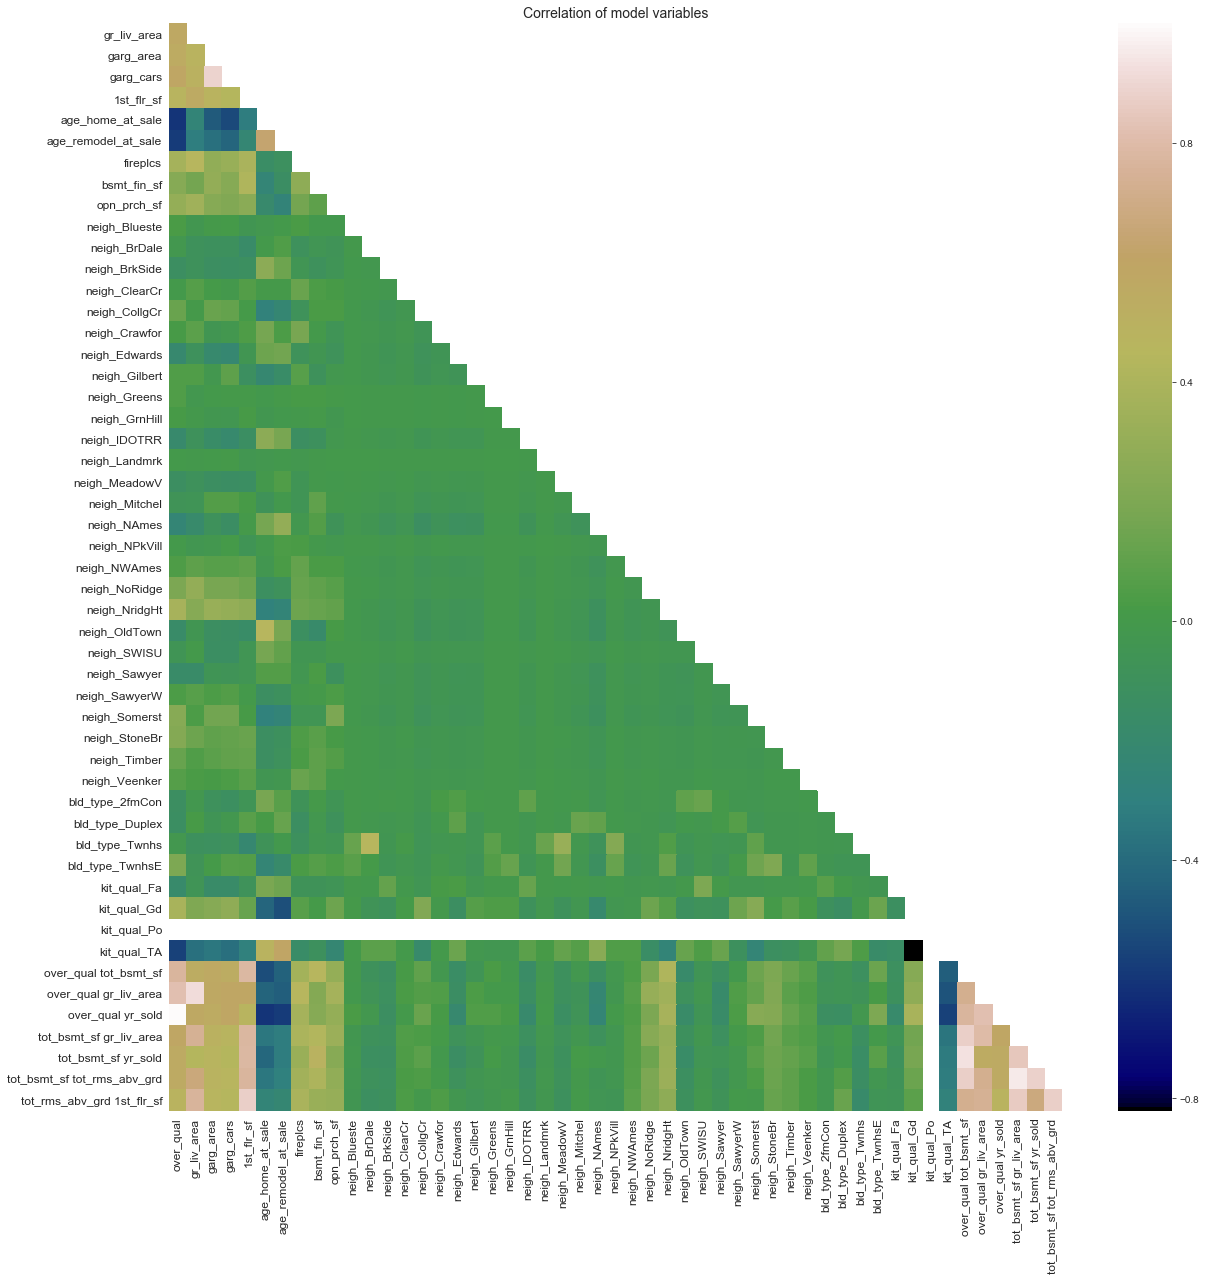

In [170]:
# Plot the correlation of the model parameters
correl_plot(X1_trn_trn[coeff], "Correlation of model variables", (20,20), False)


### Use the eval_model function to examine predictions and residuals

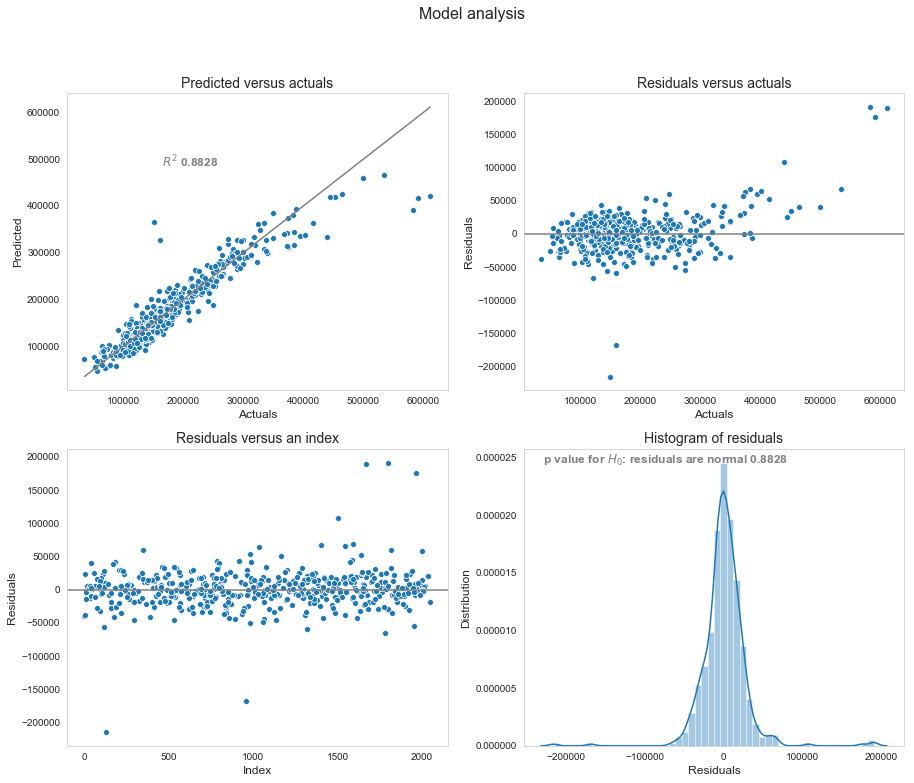

In [171]:
# Examine the predictions
eval_model(y_trn_tst, pred_lr_pl_trn_tst)


### Create a large scatter for the presentation

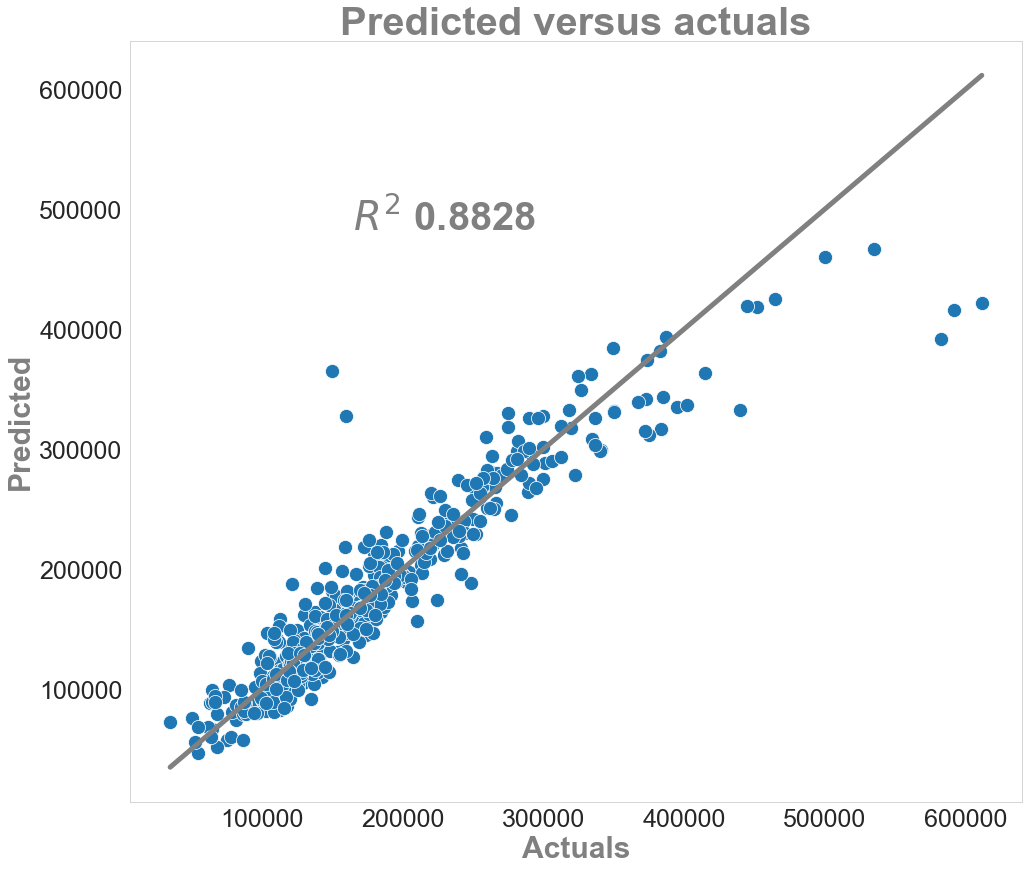

In [307]:
# Large scatter plot for presentation
large_scatter(y_trn_tst, pred_lr_pl_trn_tst)


## Train this model on the entire training set

In [173]:
# Train the model on the entire set
model_lr = lr.fit(X1_trn[coeff], y_trn)
pred_lr_pl_tst = model_lr.predict(X1_tst[coeff])


### Write to a file


In [174]:
# write the test set predictions to a file
write_pred(pd.DataFrame(pred_lr_pl_tst),"pred_3f_Steve_Godfrey.csv" )


## Try a Lasso model

### Scale the data

In [177]:
# Scale the data
ss = StandardScaler()
ss.fit(X1_trn_trn)
X1_trn_trn_s = pd.DataFrame(ss.transform(X1_trn_trn))
X1_trn_trn_s.columns = X1_trn_trn.columns
X1_trn_tst_s = pd.DataFrame(ss.transform(X1_trn_tst))
X1_trn_tst_s.columns = X1_trn_tst.columns


In [178]:
# Instantiate and fit model
ls = LassoCV()
model_ls = ls.fit(X1_trn_trn_s[coeff], y_trn_trn)
pred_lr_pl_trn_tst_ls = model_ls.predict(X1_trn_tst_s[coeff])
print(cross_val_score(ls,X1_trn_trn_s,y_trn_trn, cv = 5).mean())


0.8272808382545491


### Use the eval_model function to examine predictions and residuals

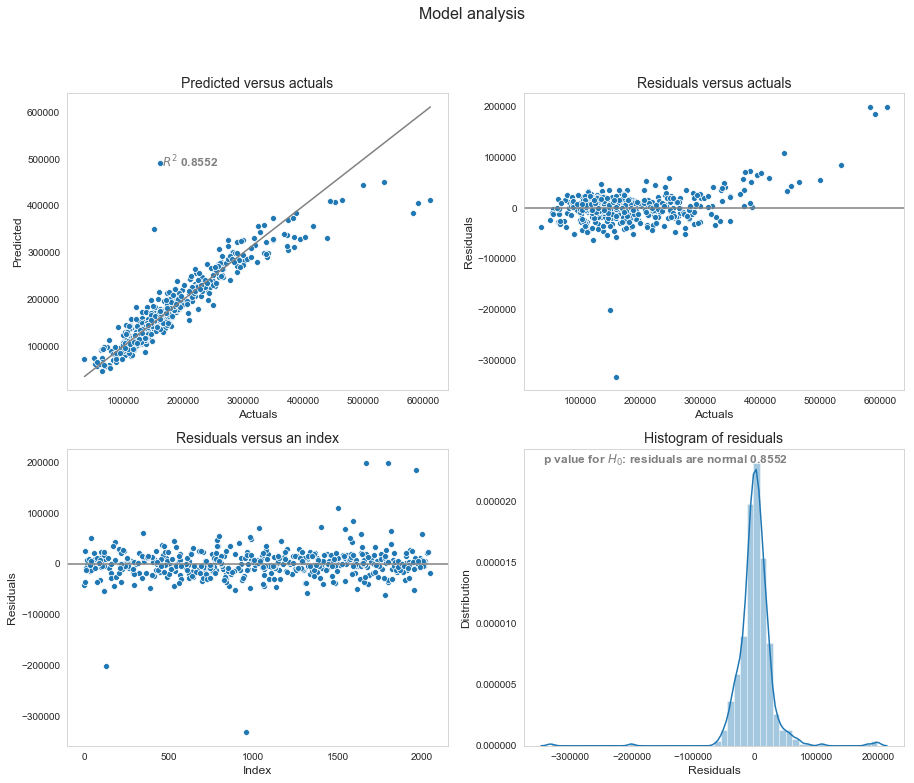

In [179]:
# Examine the predictions
eval_model(y_trn_tst, pred_lr_pl_trn_tst_ls)


### Scale the data using the entire training set

In [180]:
# Scale the data
ss = StandardScaler()
ss.fit(X1_trn)
X1_trn_s = pd.DataFrame(ss.transform(X1_trn))
X1_trn_s.columns = X1_trn.columns
X1_tst_s = pd.DataFrame(ss.transform(X1_tst))
X1_tst_s.columns = X1_tst.columns


### Update the model using the entire training set

In [181]:
# Instantiate and fit model
ls = LassoCV()
model_ls = ls.fit(X1_trn_s[coeff], y_trn)
pred_lr_pl_tst_ls = model_ls.predict(X1_tst_s[coeff])


### Get the coefficients and model parameters

In [188]:
# Get the intercept and coefficients
df = pd.DataFrame(model_ls.coef_, index = coeff, columns=['weights'])
df

,weights
over_qual,-1855.065475
gr_liv_area,6582.662091
garg_area,3689.449098
garg_cars,1708.017363
1st_flr_sf,8846.129837
age_home_at_sale,-7402.032670
age_remodel_at_sale,-6616.043836
fireplcs,4107.524252
bsmt_fin_sf,9887.429552
opn_prch_sf,0.000000


In [189]:
print(df.index)

Index(['over_qual', 'gr_liv_area', 'garg_area', 'garg_cars', '1st_flr_sf',
       'age_home_at_sale', 'age_remodel_at_sale', 'fireplcs', 'bsmt_fin_sf',
       'opn_prch_sf', 'neigh_Blueste', 'neigh_BrDale', 'neigh_BrkSide',
       'neigh_ClearCr', 'neigh_CollgCr', 'neigh_Crawfor', 'neigh_Edwards',
       'neigh_Gilbert', 'neigh_Greens', 'neigh_GrnHill', 'neigh_IDOTRR',
       'neigh_Landmrk', 'neigh_MeadowV', 'neigh_Mitchel', 'neigh_NAmes',
       'neigh_NPkVill', 'neigh_NWAmes', 'neigh_NoRidge', 'neigh_NridgHt',
       'neigh_OldTown', 'neigh_SWISU', 'neigh_Sawyer', 'neigh_SawyerW',
       'neigh_Somerst', 'neigh_StoneBr', 'neigh_Timber', 'neigh_Veenker',
       'bld_type_2fmCon', 'bld_type_Duplex', 'bld_type_Twnhs',
       'bld_type_TwnhsE', 'kit_qual_Fa', 'kit_qual_Gd', 'kit_qual_Po',
       'kit_qual_TA', 'over_qual tot_bsmt_sf', 'over_qual gr_liv_area',
       'over_qual yr_sold', 'tot_bsmt_sf gr_liv_area', 'tot_bsmt_sf yr_sold',
       'tot_bsmt_sf tot_rms_abv_grd', 'tot_rms_abv_

In [190]:
# Get the alpha parameter
model_ls.alpha_


66.33537981815421

### Write to a file

In [191]:
# write the test set predictions to a file
write_pred(pd.DataFrame(pred_lr_pl_tst_ls),"pred_4f_Steve_Godfrey.csv" )


## Use cat_evaluator to pick the best interaction variables

In [192]:
# create a list of interaction variables
interact_var = []
for item in pl_coeff:
    if item not in lr_coeff:
       interact_var.append([item])

# create a list of lists for the lr_coeff
base_var = []
base_var.append(lr_coeff)


In [193]:
# add the interact_variables to the lr_coeff to find the best additions
interaction_models = cat_evaluator(X1_trn_trn, y_trn_trn, interact_var, base_var, 2, 4, linear_model = 'line_regr')


In [194]:
# Look at the top models with categorical variables
interaction_models.sort_values(by ='CV R2', ascending = False).head()


,CV R2,Coeff,Combo,Intercept,Model,Pred
12,0.863276,"[[-57887.70577216072, 39.89252018784314, 19.59...","[over_qual, gr_liv_area, garg_area, garg_cars,...",[74824.72296538873],line_regr,"[[41055.421200889505], [196543.78907454252], [..."
4,0.861347,"[[3464.1721814369384, 60.0066471262296, 13.375...","[over_qual, gr_liv_area, garg_area, garg_cars,...",[104086.41197111155],line_regr,"[[48765.68804931584], [196761.2331072092], [18..."
28,0.860719,"[[30209.22993851073, 60.00247789036484, 13.388...","[over_qual, gr_liv_area, garg_area, garg_cars,...",[104102.38551272787],line_regr,"[[48706.25922626043], [196819.3122684211], [18..."
1,0.855809,"[[-57935.24095317483, 40.57770516257075, 19.38...","[over_qual, gr_liv_area, garg_area, garg_cars,...",[85151.8216365529],line_regr,"[[44193.88411304078], [196752.98624031845], [1..."
19,0.854479,"[[11706.740209700542, 55.62916621716455, 15.28...","[over_qual, gr_liv_area, garg_area, garg_cars,...",[57974.422631043635],line_regr,"[[34846.166539592174], [196029.40019878838], [..."


In [195]:
# Get the top performing model
interact_best_model = list(interaction_models.sort_values(by = 'CV R2', ascending = False)['Combo'][:1])


In [200]:
# interaction model coefficients
print(interact_best_model)

[['over_qual', 'gr_liv_area', 'garg_area', 'garg_cars', '1st_flr_sf', 'age_home_at_sale', 'age_remodel_at_sale', 'fireplcs', 'bsmt_fin_sf', 'opn_prch_sf', 'neigh_Blueste', 'neigh_BrDale', 'neigh_BrkSide', 'neigh_ClearCr', 'neigh_CollgCr', 'neigh_Crawfor', 'neigh_Edwards', 'neigh_Gilbert', 'neigh_Greens', 'neigh_GrnHill', 'neigh_IDOTRR', 'neigh_Landmrk', 'neigh_MeadowV', 'neigh_Mitchel', 'neigh_NAmes', 'neigh_NPkVill', 'neigh_NWAmes', 'neigh_NoRidge', 'neigh_NridgHt', 'neigh_OldTown', 'neigh_SWISU', 'neigh_Sawyer', 'neigh_SawyerW', 'neigh_Somerst', 'neigh_StoneBr', 'neigh_Timber', 'neigh_Veenker', 'bld_type_2fmCon', 'bld_type_Duplex', 'bld_type_Twnhs', 'bld_type_TwnhsE', 'kit_qual_Fa', 'kit_qual_Gd', 'kit_qual_Po', 'kit_qual_TA', 'over_qual yr_sold', 'tot_bsmt_sf yr_sold']]


## Put these variables into an OLS model

In [201]:
# Run a linear regression
model_interact = lr.fit(X1_trn_trn[interact_best_model[0]], y_trn_trn)
pred_interact_trn_tst = model_interact.predict(X1_trn_tst[interact_best_model[0]])
print(cross_val_score(lr,X1_trn[interact_best_model[0]],y_trn, cv = 5).mean())



0.8564746023828136


### Use the statsmodels api to see a summary of the regression

In [202]:
# Uses stats models to view the lr summary results
results = view_lr_summary(X1_trn_trn[interact_best_model[0]], y_trn_trn)
results


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             sale_price   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     251.5
Date:                Thu, 21 Mar 2019   Prob (F-statistic):               0.00
Time:                        07:38:44   Log-Likelihood:                -17845.
No. Observations:                1538   AIC:                         3.578e+04
Df Residuals:                    1491   BIC:                         3.603e+04
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                7.482e+04   1.05e+04      7.094      0.000    5.41e+04    9.55e+04
over_qual           -5.789e+04   1.74e+05     -0.332      0.740      -4e+05    2.84e+05
gr_liv_area            39.8925      2.236     17.839      0.000      35.506      44.279
garg_area              19.5958      7.824      2.505      0.012       4.248      34.943
garg_cars            3622.4677   2240.407      1.617      0.106    -772.216    8017.152
1st_flr_sf              7.0711      3.351      2.110      0.035       0.498      13.644
age_home_at_sale     -248.4686     54.013     -4.600      0.000    -354.418    -142.520
age_remodel_at_sale  -262.3718     50.568     -5.189      0.000    -361.563    -163.181
fireplcs             6439.6052   1385.536      4.648      0.000    3721.798    9157.413
bsmt_fin_sf            21.0760      1.917     10.993      0.000      17.315      24.837
opn_prch_sf            -2.4098     11.533     -0.209      0.835     -25.033      20.214
neigh_Blueste       -4722.3513   1.52e+04     -0.310      0.757   -3.46e+04    2.52e+04
neigh_BrDale        -5680.6641   1.06e+04     -0.534      0.593   -2.65e+04    1.52e+04
neigh_BrkSide       -2.253e+04   8583.381     -2.625      0.009   -3.94e+04   -5694.998
neigh_ClearCr          77.1123   9398.015      0.008      0.993   -1.84e+04    1.85e+04
neigh_CollgCr       -2.004e+04   7410.275     -2.704      0.007   -3.46e+04   -5500.868
neigh_Crawfor       -2518.5027   8247.099     -0.305      0.760   -1.87e+04    1.37e+04
neigh_Edwards       -2.659e+04   7895.883     -3.368      0.001   -4.21e+04   -1.11e+04
neigh_Gilbert       -2.317e+04   7629.578     -3.037      0.002   -3.81e+04   -8208.486
neigh_Greens        -8014.8202   2.04e+04     -0.393      0.694    -4.8e+04     3.2e+04
neigh_GrnHill        1.051e+05   2.02e+04      5.195      0.000    6.54e+04    1.45e+05
neigh_IDOTRR        -2.755e+04   8871.307     -3.106      0.002    -4.5e+04   -1.01e+04
neigh_Landmrk       -5192.3733   2.82e+04     -0.184      0.854   -6.05e+04    5.01e+04
neigh_MeadowV       -2737.3039   9695.171     -0.282      0.778   -2.18e+04    1.63e+04
neigh_Mitchel       -2.106e+04   7987.735     -2.636      0.008   -3.67e+04   -5389.728
neigh_NAmes         -2.377e+04   7678.258     -3.096      0.002   -3.88e+04   -8707.625
neigh_NPkVill       -4384.3750   1.09e+04     -0.402      0.688   -2.58e+04     1.7e+04
neigh_NWAmes        -2.667e+04   7913.107     -3.371      0.001   -4.22e+04   -1.11e+04
neigh_NoRidge        2.075e+04   8466.372      2.451      0.014    4145.654    3.74e+04
neigh_NridgHt        2.312e+04   7437.540      3.108      0.002    8528.816    3.77e+04
neigh_OldTown       -2.903e+04   8426.922     -3.445      0.001   -4.56e+04   -1.25e+04
neigh_SWISU         -2.948e+04   9699.697     -3.039      0.002   -4.85e+04   -1.04e+04
nei

### Use the eval_model function to examine predictions and residuals

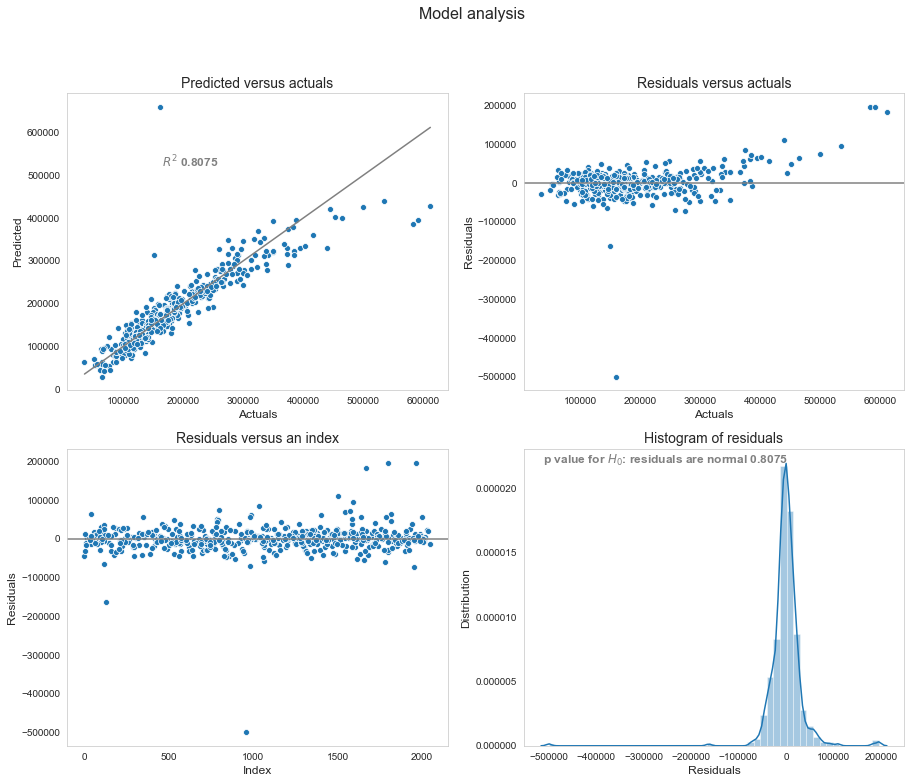

In [203]:
# Look at various plots of the residuals
eval_model(y_trn_tst, pred_interact_trn_tst)


### Look for multicollinearity

From the above results, it is clear that this model suffers for multicollinearity issues and that the coefficients and predictions may not be valid when applied to new data sets.


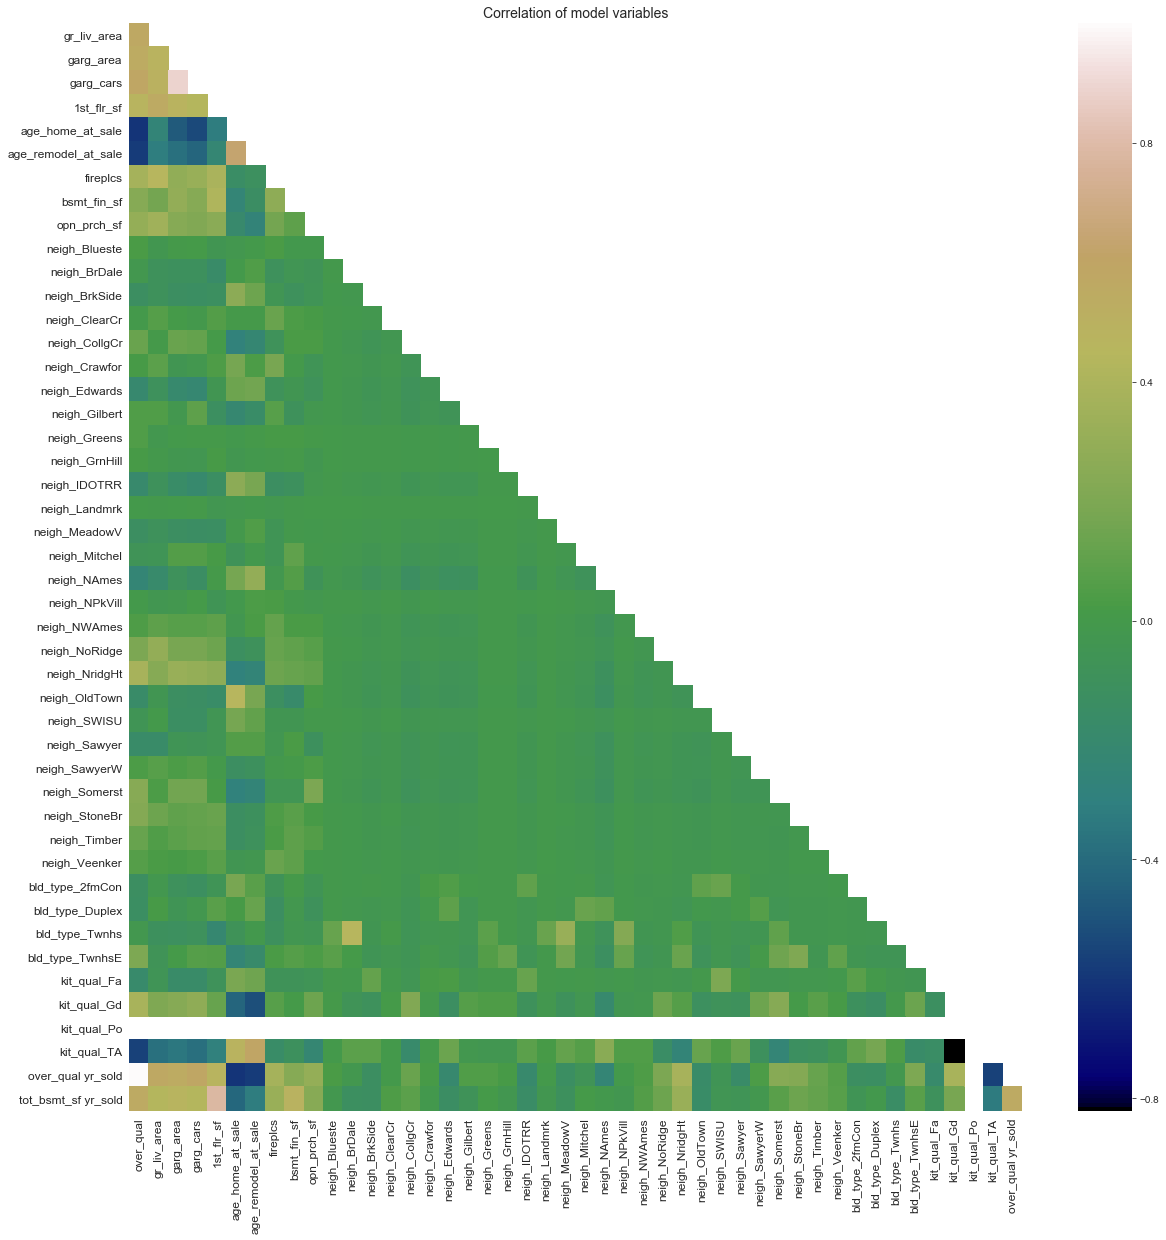

In [329]:
# Plot the correlation of the model parameters
correl_plot(X1_trn_trn[interact_best_model[0]], "Correlation of model variables", (20,20), False)


## Update this model on the entire training set


In [204]:
# Train the model on the entire set
model_lr = lr.fit(X1_trn[interact_best_model[0]], y_trn)
pred_interact_tst = model_lr.predict(X1_tst[interact_best_model[0]])


## Write a file

In [205]:
# write the test set predictions to a file
write_pred(pd.DataFrame(pred_interact_tst),"pred_5f_Steve_Godfrey.csv" )


## Use judgment to simplify the model and select the variables

In [321]:
# Use judgment to pick variables
coeff_h = ['over_qual', 'gr_liv_area', 'garg_area', 'garg_cars', '1st_flr_sf', 'age_home_at_sale', 
           'age_remodel_at_sale', 'fireplcs', 'bsmt_fin_sf', 'opn_prch_sf', 'neigh_Blueste', 'neigh_BrDale', 
           'neigh_BrkSide', 'neigh_ClearCr', 'neigh_CollgCr', 'neigh_Crawfor', 'neigh_Edwards', 
           'neigh_Gilbert', 'neigh_Greens', 'neigh_GrnHill', 'neigh_IDOTRR', 'neigh_Landmrk', 
           'neigh_MeadowV', 'neigh_Mitchel', 'neigh_NAmes', 'neigh_NPkVill', 'neigh_NWAmes', 'neigh_NoRidge', 
           'neigh_NridgHt', 'neigh_OldTown', 'neigh_SWISU', 'neigh_Sawyer', 'neigh_SawyerW', 
           'neigh_Somerst', 'neigh_StoneBr', 'neigh_Timber', 'neigh_Veenker', 'bld_type_2fmCon', 
           'bld_type_Duplex', 'bld_type_Twnhs', 'bld_type_TwnhsE', 'kit_qual_Fa', 'kit_qual_Gd', 
           'kit_qual_Po', 'kit_qual_TA', 'over_qual tot_bsmt_sf', 'over_qual gr_liv_area', 
           'over_qual yr_sold', 'tot_bsmt_sf gr_liv_area', 'tot_bsmt_sf yr_sold', 
           'tot_bsmt_sf tot_rms_abv_grd', 'tot_rms_abv_grd 1st_flr_sf']

coeff_h = ['over_qual', 'gr_liv_area', 'tot_bsmt_sf', 'age_home_at_sale', 'age_remodel_at_sale', 
           'lot_area', 'neigh_Blueste', 'neigh_BrDale', 'neigh_BrkSide', 'neigh_ClearCr', 'neigh_CollgCr', 
           'neigh_Crawfor', 'neigh_Edwards', 'neigh_Gilbert', 'neigh_Greens', 'neigh_GrnHill', 'neigh_IDOTRR', 
           'neigh_Landmrk', 'neigh_MeadowV', 'neigh_Mitchel', 'neigh_NAmes', 'neigh_NPkVill', 'neigh_NWAmes', 
           'neigh_NoRidge', 'neigh_NridgHt', 'neigh_OldTown', 'neigh_SWISU', 'neigh_Sawyer', 'neigh_SawyerW', 
           'neigh_Somerst', 'neigh_StoneBr', 'neigh_Timber', 'neigh_Veenker', 'lot_area over_qual', 
           'over_qual gr_liv_area', 'over_qual yr_sold']



### Model using OLS

In [322]:
# Instantiate the model
lr = LinearRegression()
model_lr = lr.fit(X1_trn_trn[coeff_h], y_trn_trn)
pred_human = model_lr.predict(X1_trn_tst[coeff_h])
print(cross_val_score(lr,X1_trn[coeff_h],y_trn, cv = 5).mean())


0.8100157444447845


### Use the statsmodels api to see a summary of the regression

In [323]:
# Uses stats models to view the lr summary results
results = view_lr_summary(X1_trn_trn[coeff_h], y_trn_trn)
results


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             sale_price   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     251.2
Date:                Thu, 21 Mar 2019   Prob (F-statistic):               0.00
Time:                        11:20:33   Log-Likelihood:                -18014.
No. Observations:                1538   AIC:                         3.610e+04
Df Residuals:                    1501   BIC:                         3.630e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  6.937e+04   1.39e+04      4.999      0.000    4.21e+04    9.66e+04
over_qual             -5.601e+05   1.92e+05     -2.910      0.004   -9.38e+05   -1.83e+05
gr_liv_area             -24.4235      7.091     -3.444      0.001     -38.334     -10.513
tot_bsmt_sf              24.3517      2.332     10.445      0.000      19.778      28.925
age_home_at_sale       -315.2566     58.699     -5.371      0.000    -430.398    -200.115
age_remodel_at_sale    -318.7996     52.274     -6.099      0.000    -421.337    -216.262
lot_area                  2.4807      0.689      3.601      0.000       1.129       3.832
neigh_Blueste         -5401.1928   1.67e+04     -0.324      0.746   -3.81e+04    2.73e+04
neigh_BrDale          -1.738e+04   1.07e+04     -1.628      0.104   -3.83e+04    3563.565
neigh_BrkSide          5473.2010   9151.159      0.598      0.550   -1.25e+04    2.34e+04
neigh_ClearCr          1.226e+04   1.05e+04      1.167      0.243   -8344.755    3.29e+04
neigh_CollgCr          1272.8154   7639.182      0.167      0.868   -1.37e+04    1.63e+04
neigh_Crawfor          2.464e+04   8876.617      2.776      0.006    7231.082    4.21e+04
neigh_Edwards         -5985.2959   8316.643     -0.720      0.472   -2.23e+04    1.03e+04
neigh_Gilbert         -4106.5333   7957.521     -0.516      0.606   -1.97e+04    1.15e+04
neigh_Greens          -1111.0632   2.24e+04     -0.050      0.961   -4.51e+04    4.29e+04
neigh_GrnHill          1.006e+05   2.24e+04      4.492      0.000    5.67e+04    1.44e+05
neigh_IDOTRR          -5638.1088   9388.953     -0.601      0.548   -2.41e+04    1.28e+04
neigh_Landmrk         -1.266e+04   3.08e+04     -0.411      0.681   -7.31e+04    4.78e+04
neigh_MeadowV         -8215.9631   1.04e+04     -0.789      0.430   -2.86e+04    1.22e+04
neigh_Mitchel          3051.6150   8292.642      0.368      0.713   -1.32e+04    1.93e+04
neigh_NAmes            4095.3419   7983.181      0.513      0.608   -1.16e+04    1.98e+04
neigh_NPkVill         -5626.5153   1.17e+04     -0.482      0.630   -2.85e+04    1.73e+04
neigh_NWAmes             88.7013   8330.423      0.011      0.992   -1.63e+04    1.64e+04
neigh_NoRidge           3.06e+04   9014.317      3.394      0.001    1.29e+04    4.83e+04
neigh_NridgHt          4.037e+04   7914.488      5.100      0.000    2.48e+04    5.59e+04
neigh_OldTown         -3543.2457   8937.326     -0.396      0.692   -2.11e+04     1.4e+04
neigh_SWISU           -6995.1773   1.03e+04     -0.678      0.498   -2.72e+04    1.32e+04
neigh_Sawyer           4555.7138   8342.403      0.546      0.585   -1.18e+04    2.09e+04
neigh_SawyerW         -4693.9803   8168.346     -0.575      0.566   -2.07e+04    1.13e+04
neigh_Somerst          1.005e+04   7730.686      1.300      0.194   -5110.606    2.52e+04
neigh_StoneBr          

### Use the eval_model function to examine predictions and residuals

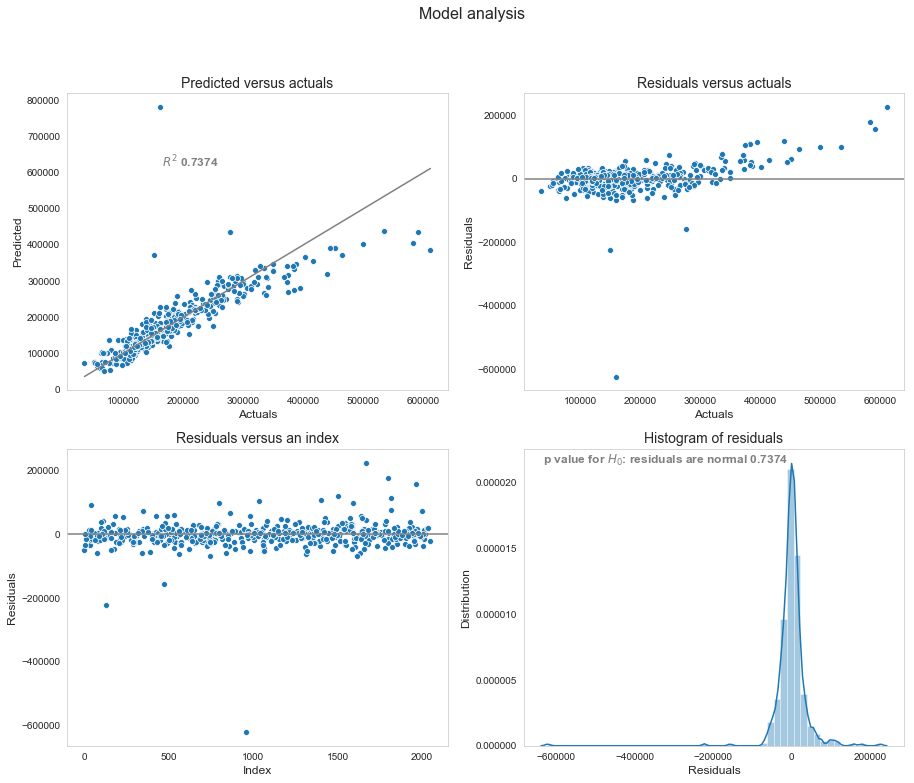

In [324]:
# Look at various plots of the residuals
eval_model(y_trn_tst, pred_human)


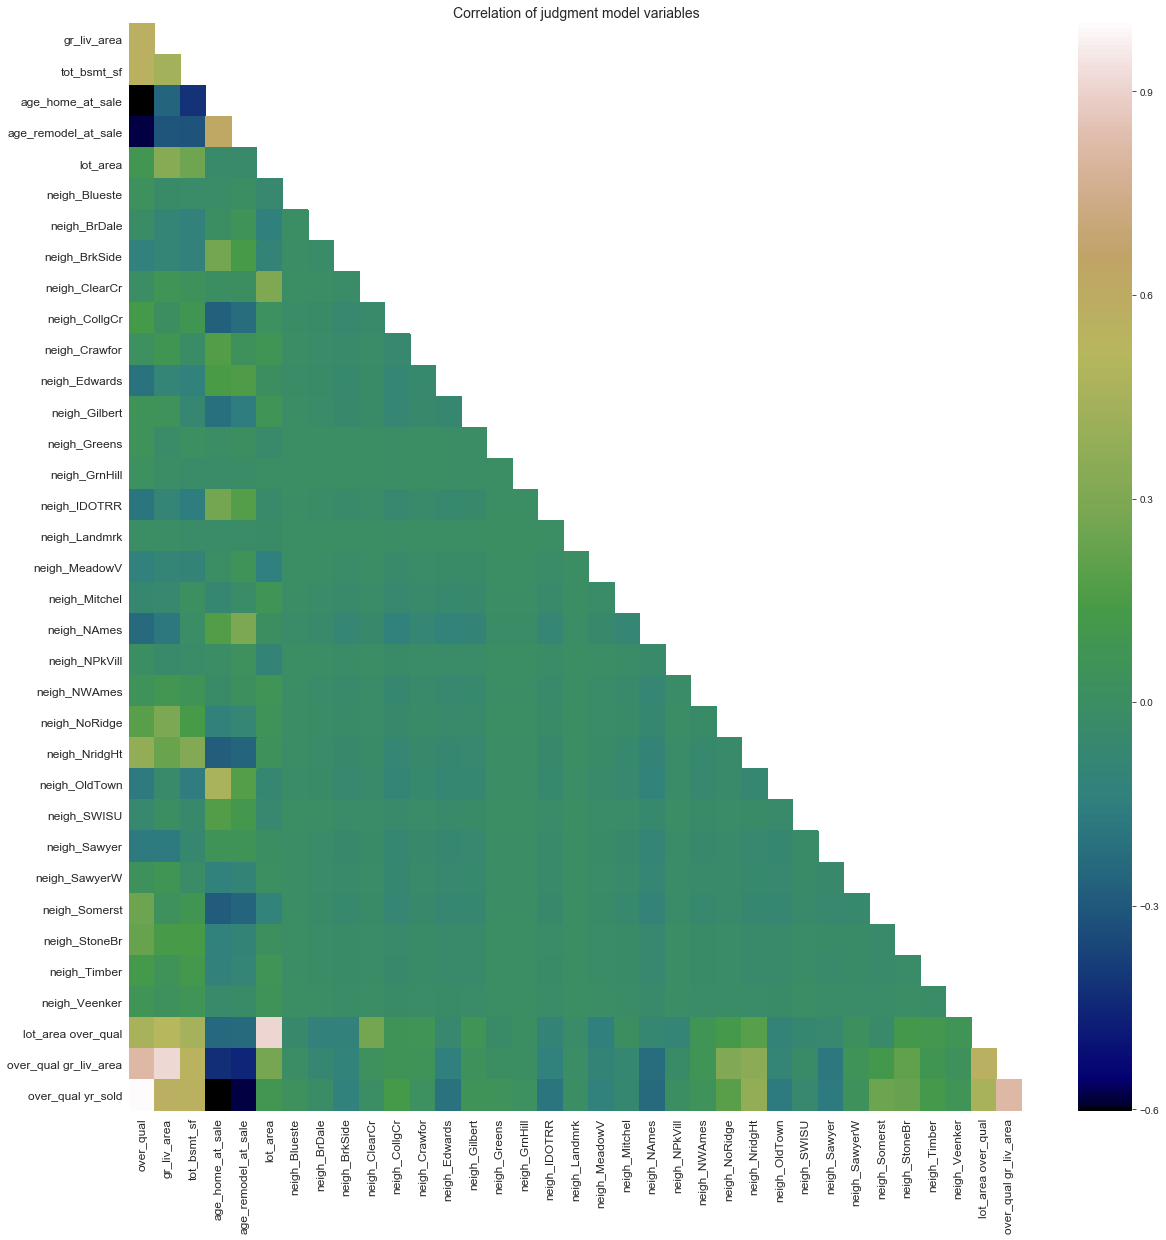

In [325]:
# Plot the correlation of the model parameters
correl_plot(X1_trn_trn[coeff_h], "Correlation of judgment model variables", (20,20), False)


### Create a large scatter for the presentation

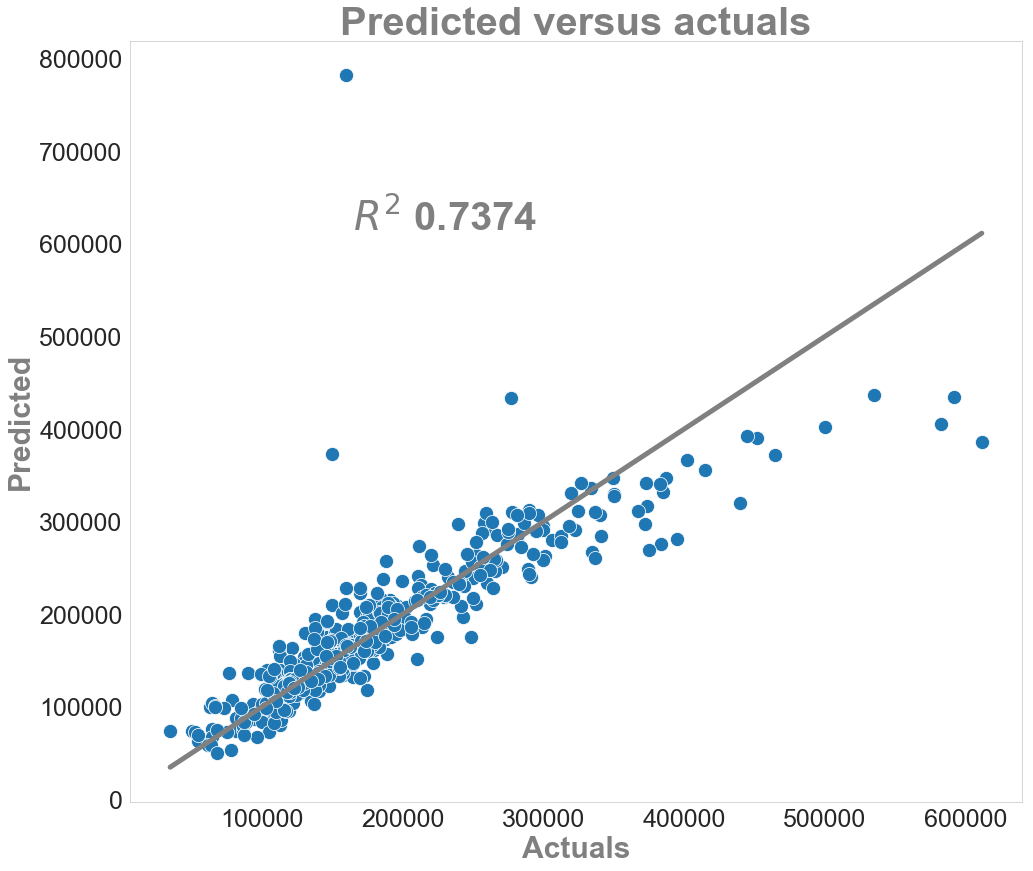

In [326]:
# Large scatter plot for presentation
large_scatter(y_trn_tst, pred_human)


### Update this model on the entire training set

In [327]:
# Train the model on the entire set
model_lr = lr.fit(X1_trn[coeff_h], y_trn)
pred_human_tst = model_lr.predict(X1_tst[coeff_h])


### Write to a file 

In [328]:
# write the test set predictions to a file
write_pred(pd.DataFrame(pred_human_tst),"pred_6f_Steve_Godfrey.csv" )
